In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

ts = TimeSeries(key='8VHYYYZR0BTCNJ2F', output_format='pandas')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import datetime
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [3]:
#df = pd.read_csv('../dataset/GOOG-year.csv')
#df.head()
df,_ = ts.get_daily(symbol='SPY', outputsize='full')
df.iloc[0:253, 3:4]

,4. close
date,
2020-03-13,263.10
2020-03-12,248.11
2020-03-11,274.36
2020-03-10,288.42
2020-03-09,274.23
2020-03-06,297.46
2020-03-05,302.46
2020-03-04,312.86
2020-03-03,300.24


In [4]:
minmax = MinMaxScaler().fit(df.iloc[0:253, 3:4].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[0:253, 3:4].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df = df.iloc[0:253, 3:4]

In [5]:
data = np.array(df)
np.save('SPY.npy', data)

In [6]:
test_size = 20
simulation_size = 5

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((253, 1), (233, 1), (20, 1))

In [7]:
# Root Mean Square Percentage Error
def calculate_accuracy(real, predict):
    #print(real)
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    #print(np.mean(np.square((real - predict) / real)))
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [8]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [9]:
class LSTM:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )


In [10]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    results.append(deep_future[-test_size:])

W0313 13:31:21.647762 140055442884416 deprecation.py:323] From <ipython-input-9-591827d2a9de>:12: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0313 13:31:21.651476 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f606429b0f0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 13:31:21.653150 140055442884416 deprecation.py:323] From <ipython-input-9-591827d2a9de>:16: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


simulation 1


W0313 13:31:22.442821 140055442884416 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0313 13:31:22.447808 140055442884416 deprecation.py:323] From <ipython-input-9-591827d2a9de>:27: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0313 13:31:22.713795 140055442884416 deprecation.py:506] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instr

0:01:47.508660


W0313 13:33:13.257429 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f6057b8efd0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:01:45.395636


W0313 13:34:59.897521 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f604c5847f0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:01:41.304690


W0313 13:36:42.208222 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f60444ed2e8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:01:38.381567


W0313 13:38:21.425765 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f6044046f28>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5
0:01:38.825230


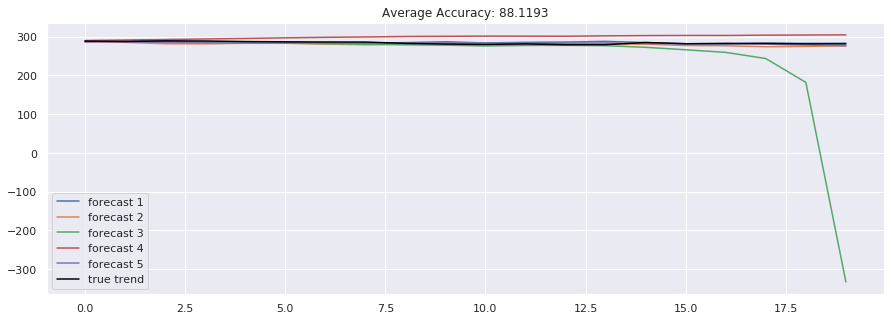

In [11]:
acc1 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results]
plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc1)))
plt.show()

In [12]:
class LSTM_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [13]:
results2 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results2.append(deep_future[-test_size:])

W0313 13:40:01.769482 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5fe478f5c0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 13:40:01.770899 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5fe478f7b8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 13:40:01.779177 140055442884416 deprecation.py:323] From <ipython-input-12-709b0a645057>:42: bidirectional_dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


simulation 1
0:02:35.165347


W0313 13:42:38.547860 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5fac3dca58>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 13:42:38.550212 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5fac30f160>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:02:37.042697


W0313 13:45:17.368114 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5f7c779ba8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 13:45:17.369611 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5f74630438>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:02:34.110002


W0313 13:47:53.111872 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5f64114c50>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 13:47:53.113628 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5f64042518>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:02:35.195799


W0313 13:50:30.076472 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5f74114f28>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 13:50:30.078954 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ef82dd518>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5
0:02:32.391052


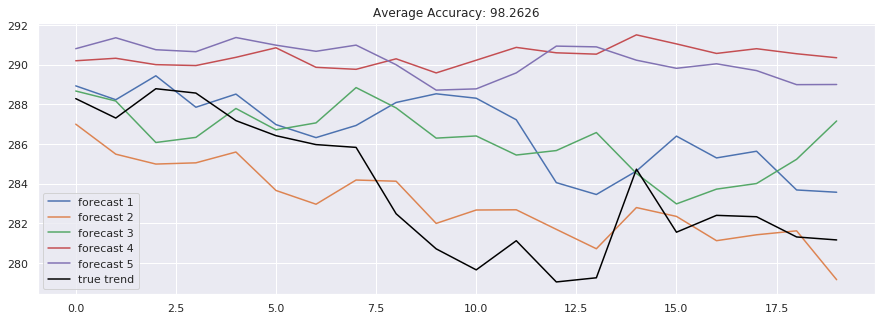

[98.60794196133793,
 99.25856935948295,
 98.61727264297214,
 97.33750229852338,
 97.49192653340948]

In [14]:
acc2 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results2]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results2):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc2)))
plt.show()
acc2

In [15]:
class LSTM_2p:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [16]:
results3 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_2p(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results3.append(deep_future[-test_size:])

W0313 13:53:04.436027 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5e843f78d0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 13:53:04.575623 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5e843880b8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1
0:02:40.002036


W0313 13:55:46.246464 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5e843f7b38>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 13:55:46.407447 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5e8442fc88>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:02:35.476981


W0313 13:58:23.341958 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5e5479bcc0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 13:58:23.460700 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5e547d70b8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:02:37.394274


W0313 14:01:02.583757 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5e1062dc50>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 14:01:02.713909 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5e2c13cb70>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:02:39.741068


W0313 14:03:43.766843 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5df008f940>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 14:03:43.896628 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5df008fb00>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5
0:02:35.281049


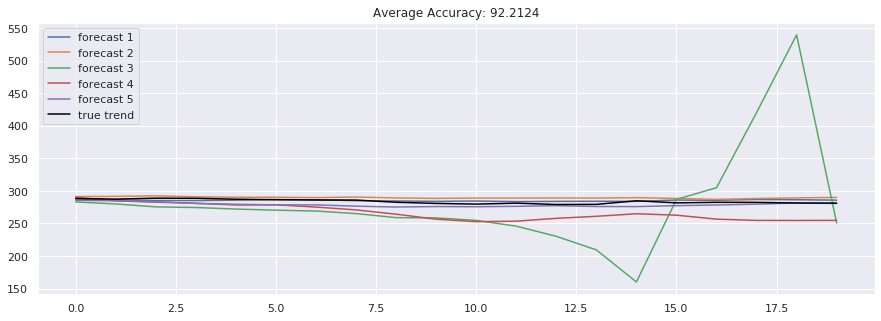

In [17]:
acc3 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results3]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results3):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc3)))
plt.show()

In [18]:
class GRU:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [19]:
results4 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results4.append(deep_future[-test_size:])

W0313 14:06:20.764691 140055442884416 deprecation.py:323] From <ipython-input-18-84b79e8d4ad3>:12: GRUCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
W0313 14:06:20.825021 140055442884416 deprecation.py:506] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/rnn_cell_impl.py:564: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


simulation 1
0:01:40.697338
simulation 2
0:01:37.504503
simulation 3
0:01:40.057051
simulation 4
0:01:39.689313
simulation 5
0:01:38.246474


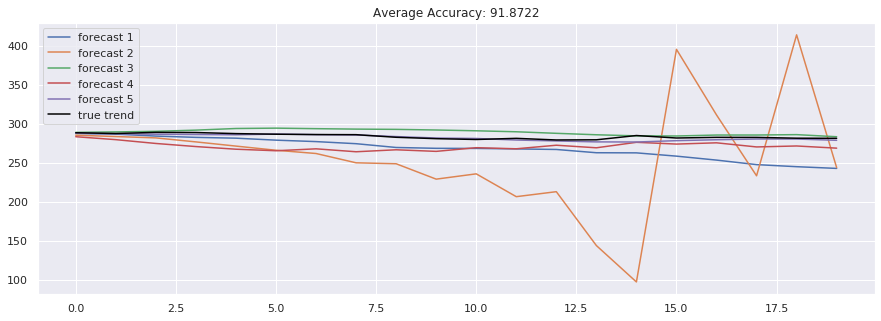

In [20]:
acc4 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results4]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results4):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc4)))
plt.show()

In [21]:
class GRU_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [22]:
results5 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results5.append(deep_future[-test_size:])

simulation 1
0:02:33.294809
simulation 2
0:02:32.047322
simulation 3
0:02:35.272818
simulation 4
0:02:32.585590
simulation 5
0:02:36.882762


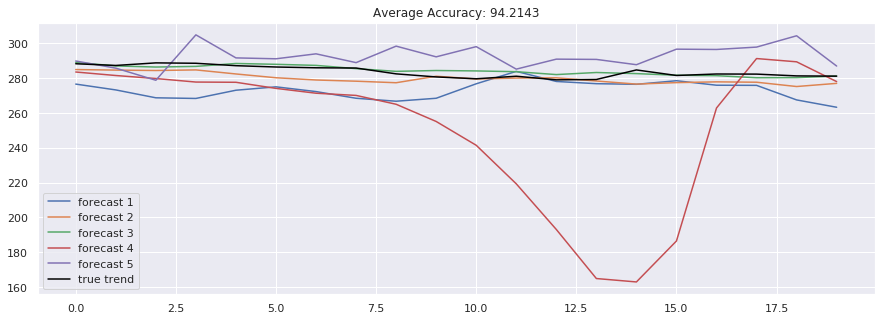

In [23]:
acc5 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results5]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results5):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc5)))
plt.show()

In [24]:
class GRU_2p:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [25]:
results6 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_2p(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results6.append(deep_future[-test_size:])

simulation 1
0:02:36.611135
simulation 2
0:02:35.411166
simulation 3
0:02:34.000961
simulation 4
0:02:30.712176
simulation 5
0:02:30.314452


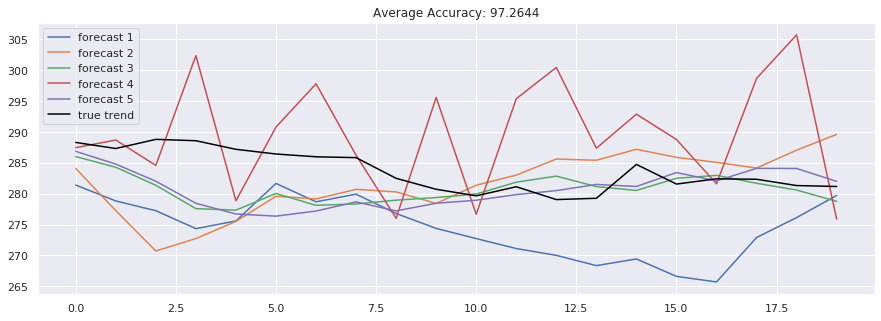

In [26]:
acc6 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results6]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results6):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc6)))
plt.show()

In [27]:
#np.save('goog_gru.npy', a)

In [28]:
class VanillaRNN:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [29]:
results7 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = VanillaRNN(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results7.append(deep_future[-test_size:])

W0313 14:40:36.515050 140055442884416 deprecation.py:323] From <ipython-input-28-5e6f446929ac>:12: BasicRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


simulation 1
0:01:08.830036
simulation 2
0:01:10.052397
simulation 3
0:01:08.232673
simulation 4
0:01:12.346014
simulation 5
0:01:14.374533


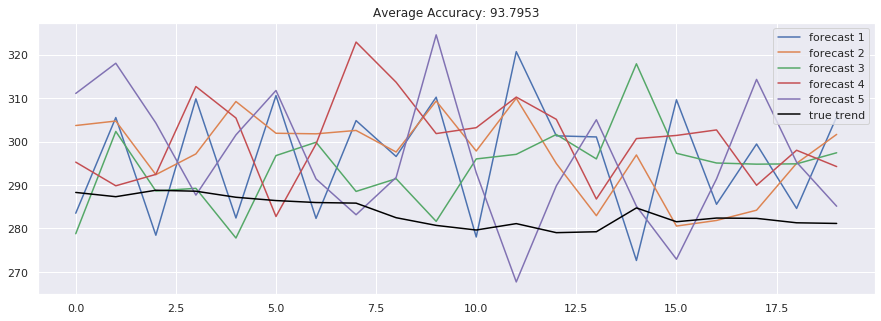

In [30]:
acc7 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results7]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results7):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc7)))
plt.show()

In [31]:
class VanillaRNN_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [32]:
results8 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = VanillaRNN_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results8.append(deep_future[-test_size:])

simulation 1
0:01:36.559001
simulation 2
0:01:33.514697
simulation 3
0:01:36.556836
simulation 4
0:01:37.742638
simulation 5
0:01:37.860478


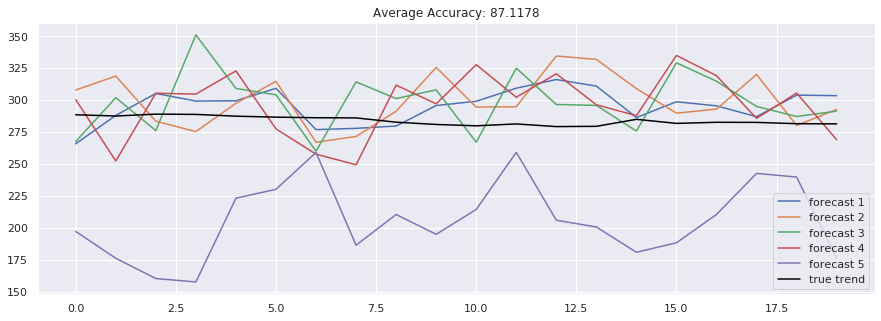

In [33]:
acc8 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results8]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results8):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc8)))
plt.show()

In [34]:
class VanillaRNN_2p:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [35]:
results9 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = VanillaRNN_2p(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results9.append(deep_future[-test_size:])

simulation 1
0:01:36.716675
simulation 2
0:01:38.979026
simulation 3
0:01:37.655367
simulation 4
0:01:40.836082
simulation 5
0:01:40.424193


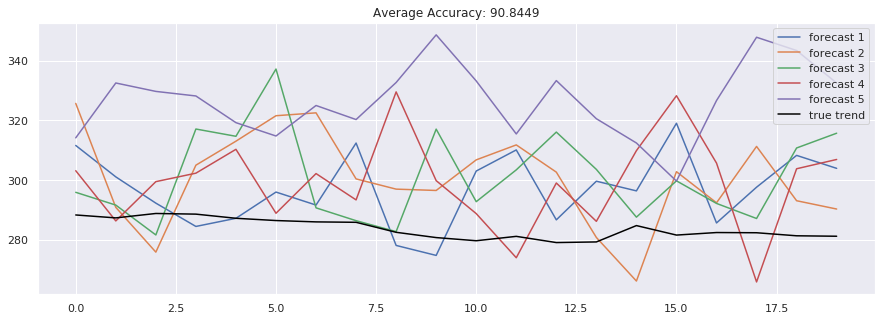

In [36]:
acc9 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results9]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results9):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc9)))
plt.show()

In [37]:
class LSTM_seq2seq:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [38]:
results10 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_seq2seq(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results10.append(deep_future[-test_size:])

W0313 15:03:03.038273 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b61db7c18>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:03:03.160463 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b61db7ef0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1
0:02:25.392079


W0313 15:05:29.781678 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b61d0da90>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:05:29.939312 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b61203630>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:02:25.241157


W0313 15:07:56.543072 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b335b58d0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:07:56.681727 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b32df3710>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:02:24.771618


W0313 15:10:22.592758 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b31358470>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:10:22.718896 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b30998828>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:02:26.981956


W0313 15:12:51.896578 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b31461550>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:12:52.020343 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b22df4b38>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5
0:02:21.964890


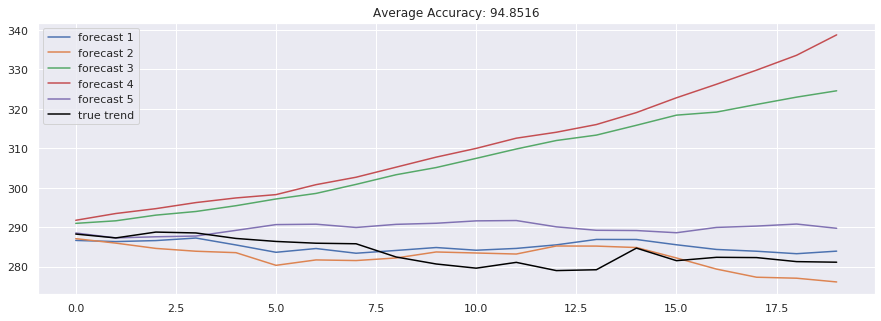

In [39]:
acc10 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results10]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results10):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc10)))
plt.show()

In [40]:
class LSTM_seq2seq_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        
        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X, 
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [41]:
results11 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_seq2seq_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results11.append(deep_future[-test_size:])

W0313 15:15:15.677484 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b20138eb8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:15:15.679598 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b200ec198>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1


W0313 15:15:15.913151 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b200ecf60>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:15:15.914514 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b200ec470>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:04:00.558038


W0313 15:19:18.881786 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b066d8b00>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:19:18.883515 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b062c7d30>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2


W0313 15:19:19.144504 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b052b28d0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:19:19.145665 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b05166588>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:03:57.541404


W0313 15:23:19.114668 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ae7580b00>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:23:19.116704 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5b040d18d0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3


W0313 15:23:19.382201 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ae62d4ef0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:23:19.383437 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ae4940198>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:04:00.824259


W0313 15:27:22.629239 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ae43ff6a0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:27:22.630840 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ae4698d30>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4


W0313 15:27:22.903426 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ad7317cc0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:27:22.904584 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ad71d7eb8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:03:58.290049


W0313 15:31:23.543844 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ad54420b8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:31:23.545324 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ad72176d8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5


W0313 15:31:23.779351 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ad43665c0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:31:23.780781 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ad4255940>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:03:52.992301


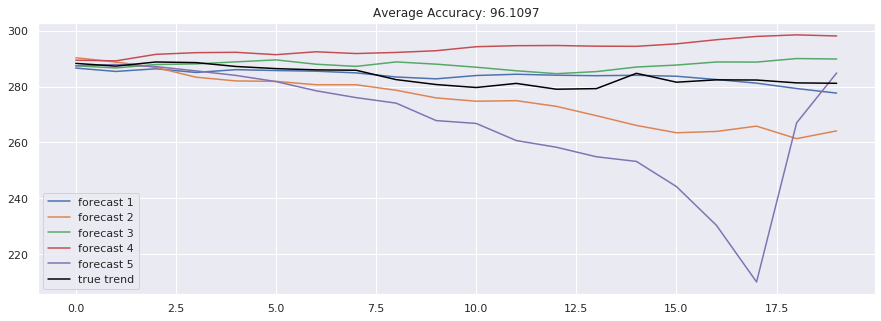

In [42]:
acc11 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results11]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results11):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc11)))
plt.show()

In [43]:
# Variational Auto-Encoder
class LSTM_seq2seq_vae:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        lambda_coeff = 0.5
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        self.z_mean = tf.layers.dense(last_state, size)
        self.z_log_sigma = tf.layers.dense(last_state, size)
        
        epsilon = tf.random_normal(tf.shape(self.z_log_sigma))
        self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            x = tf.concat([tf.expand_dims(self.z_vector, axis=0), self.X], axis = 1)
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.lambda_coeff = lambda_coeff
        
        self.kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * self.z_log_sigma - self.z_mean ** 2 - 
                             tf.exp(2 * self.z_log_sigma), 1)
        self.kl_loss = tf.scalar_mul(self.lambda_coeff, self.kl_loss)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [44]:
results12 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_seq2seq_vae(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
           
    fin = datetime.datetime.now()
    print(fin-now)
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results12.append(deep_future[-test_size:])

W0313 15:35:20.559080 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ac02e8ac8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:35:20.712074 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ac2b73128>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1
0:02:26.809852


W0313 15:37:48.734219 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ac02e8d30>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:37:48.918023 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5abbeb8cf8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:02:22.188348


W0313 15:40:12.481173 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ab9200e10>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:40:12.677798 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5ab899cb70>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:02:26.341255


W0313 15:42:40.354403 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5a9af72208>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0313 15:42:40.517013 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5a98bc3940>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:02:24.580007


W0313 15:45:06.520964 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5a988322e8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5


W0313 15:45:06.750044 140055442884416 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f5a7e6da198>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:02:28.454186


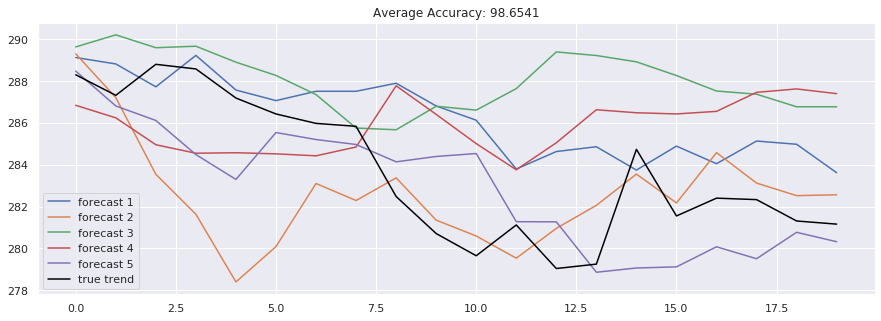

In [45]:
acc12 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results12]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results12):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc12)))
plt.show()

In [46]:
class GRU_seq2seq:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [47]:
results13 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_seq2seq(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results13.append(deep_future[-test_size:])

simulation 1
0:02:24.748829
simulation 2
0:02:22.646866
simulation 3
0:02:22.897125
simulation 4
0:02:20.606378
simulation 5
0:02:22.577236


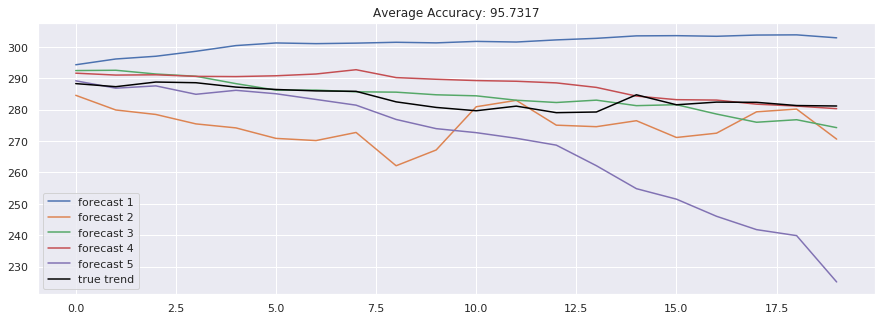

In [48]:
acc13 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results13]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results13):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc13)))
plt.show()

In [49]:
class GRU_seq2seq_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        
        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X, 
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [50]:
results14 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_seq2seq_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results14.append(deep_future[-test_size:])

simulation 1
0:03:54.128253
simulation 2
0:03:58.811271
simulation 3
0:03:59.527905
simulation 4
0:03:53.755975
simulation 5
0:04:15.426455


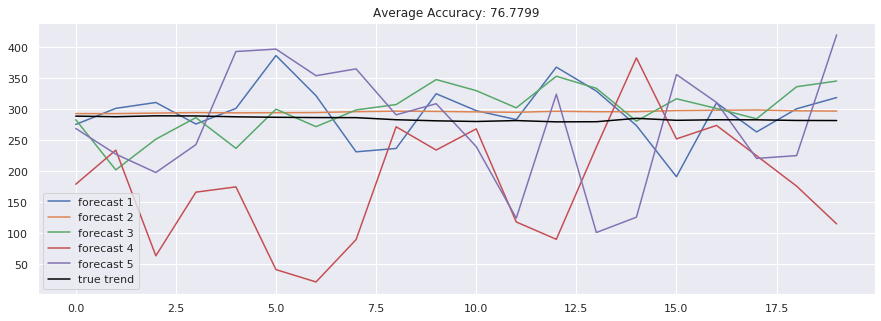

In [51]:
acc14 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results14]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results14):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc14)))
plt.show()

In [52]:
class GRU_seq2seq_vae:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        lambda_coeff = 0.5
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        self.z_mean = tf.layers.dense(last_state, size)
        self.z_log_sigma = tf.layers.dense(last_state, size)
        
        epsilon = tf.random_normal(tf.shape(self.z_log_sigma))
        self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            x = tf.concat([tf.expand_dims(self.z_vector, axis=0), self.X], axis = 1)
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.lambda_coeff = lambda_coeff
        
        self.kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * self.z_log_sigma - self.z_mean ** 2 - 
                             tf.exp(2 * self.z_log_sigma), 1)
        self.kl_loss = tf.scalar_mul(self.lambda_coeff, self.kl_loss)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [53]:
results15 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_seq2seq_vae(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size
    
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results15.append(deep_future[-test_size:])

simulation 1
0:02:26.782214
simulation 2
0:02:32.545526
simulation 3
0:02:33.197270
simulation 4
0:02:37.983605
simulation 5
0:02:39.568665


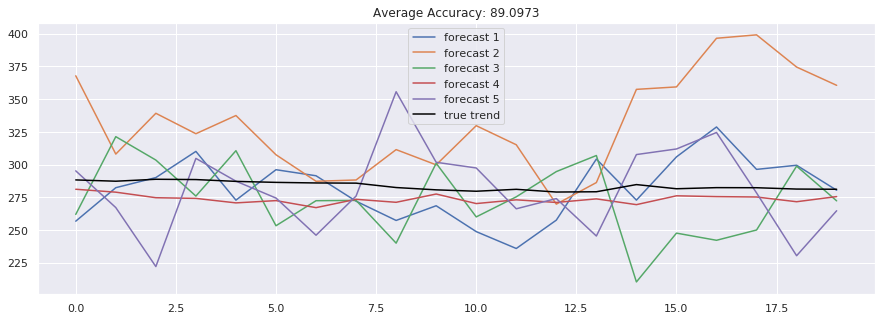

In [54]:
acc15 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results15]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results15):
    plt.plot(r, label = 'forecast %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('Average Accuracy: %.4f'%(np.mean(acc15)))
plt.show()

In [55]:
a1 = np.array(results)
a2 = np.array(results2)
a3 = np.array(results3)
a4 = np.array(results4)
a5 = np.array(results5)
a6 = np.array(results6)
a7 = np.array(results7)
a8 = np.array(results8)
a9 = np.array(results9)
a10 = np.array(results10)
a11 = np.array(results11)
a12 = np.array(results12)
a13 = np.array(results13)
a14 = np.array(results14)
a15 = np.array(results15)

In [56]:
np.save('spy_lstm.npy', a1)
np.save('spy_lstm_bid.npy', a2)
np.save('spy_lstm_2p.npy', a3)
np.save('spy_gru.npy', a4)
np.save('spy_gru_bid.npy', a5)
np.save('spy_gru_2p.npy', a6)
np.save('spy_vrnn.npy', a7)
np.save('spy_vrnn_bid.npy', a8)
np.save('spy_vrnn_2p.npy', a9)
np.save('spy_seq2seq.npy', a10)
np.save('spy_seq2seq_vae.npy', a12)
np.save('spy_seq2seq_bid.npy', a11)
np.save('spy_grubid_seq2seq.npy', a14)
np.save('spy_gru_seq2seq.npy', a13)
np.save('spy_gruvae_seq2seq.npy', a15)